In [1]:
import theano
import theano.tensor as T
import lasagne as L

from theano.printing import Print as TPP

import time
from IPython import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla M2090 (CNMeM is disabled, cuDNN not available)


In [2]:
%run ../lstm_optimizer_drop.py

In [3]:
class LSTMOptimizer:
    def __init__(self, input_var, func, func_params, loss_type='sum', lambd=1e-5, **kwargs):
        n_steps = T.iscalar()
        
        l_input = L.layers.InputLayer(shape=(None,), input_var=input_var)
        self.l_optim = LSTMOptimizerLayer(l_input, n_steps=n_steps, function=func, **kwargs)
        
        self.params_init = L.layers.get_all_param_values(self.l_optim)

        theta_history, loss_history, scan_updates = L.layers.get_output(self.l_optim)

        self.loss_type = loss_type
        if loss_type == 'sum':
            loss = loss_history.sum()
        elif loss_type == 'prod':
            loss = T.log(loss_history).sum()
        elif loss_type == 'weighted_prod':
            loss = (T.log(loss_history) * 0.9**T.arange(loss_history.shape[0])[::-1]).sum()
                
        loss += lambd * L.regularization.regularize_network_params(self.l_optim, L.regularization.l2)
                
        self.lr = theano.shared(np.array(0.01, dtype=np.float32))

        params = L.layers.get_all_params(self.l_optim)
        updates = L.updates.adam(loss, params, learning_rate=self.lr)
        updates.update(scan_updates)
        
        self.loss_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], allow_input_downcast=True, updates=scan_updates)
        self.train_fn = theano.function([input_var, n_steps] + func_params, [theta_history, loss_history], updates=updates, allow_input_downcast=True)
        
        theta_history_det, loss_history_det, scan_updates_det = L.layers.get_output(self.l_optim, deterministic=True)
        self.loss_det_fn = theano.function([input_var, n_steps] + func_params, [theta_history_det, loss_history_det], allow_input_downcast=True, updates=scan_updates_det)
        
    def reset_network(self):
        L.layers.set_all_param_values(self.l_optim, self.params_init)
        
    def train(self, sample_function, n_iter=100, n_epochs=50, batch_size=100, decay_rate=0.96):
        optimizer_loss = []
        optimizer_moving_loss = []
        moving_loss = None

#         fig = plt.figure(figsize=(15, 12))
        
        for i in range(n_epochs):
            t = time.time()    

            training_loss_history = []
            for j in range(batch_size):
                theta, params = sample_function()
 
                theta_history, loss_history = self.train_fn(theta, n_iter, *params)
                if self.loss_type == 'sum':
                    loss = np.sum(loss_history)
                else:
                    loss = np.sum(np.log(loss_history))
                training_loss_history.append(loss_history)
            
                optimizer_loss.append(loss)
                if moving_loss is None:
                    moving_loss = loss
                else:
                    moving_loss = 0.9 * moving_loss + 0.1 * loss
                optimizer_moving_loss.append(moving_loss)

            display.clear_output(wait=True)
#             fig.clear()
            
#             ax = fig.add_subplot(2, 1, 2)
#             ax.semilogy(np.median(training_loss_history, axis=0))
#             #plt.subplot(2, 1, 2)
            #plt.semilogy(np.median(training_loss_history, axis=0))

#             ax = fig.add_subplot(2, 1, 1)
            #plt.subplot(2, 1, 1)
#             if self.loss_type == 'sum':
#                 ax.semilogy(optimizer_loss, 'b', label='loss')
#                 ax.semilogy(optimizer_moving_loss, 'r', label='moving loss')
#                 #plt.semilogy(optimizer_loss, 'b', label='loss')
#                 #plt.semilogy(optimizer_moving_loss, 'r', label='moving loss')
#             else:
#                 ax.plot(optimizer_loss, 'b', label='loss')
#                 ax.plot(optimizer_moving_loss, 'r', label='moving loss')
#                 #plt.plot(optimizer_loss, 'b', label='loss')
#                 #plt.plot(optimizer_moving_loss, 'r', label='moving loss')

#             fig.canvas.draw()
#             #plt.show()
            print("Epoch number {}".format(i))
            t = time.time() - t

            print("Time on epoch {}: {}".format(i, t))
            print("Loss on {}: {}; {}".format(i, loss, np.median(training_loss_history, axis=0)[-1]))

            self.lr.set_value((self.lr.get_value() * decay_rate).astype(np.float32))
            
    def optimize(self, theta, func_params, n_iter):
        return self.loss_fn(theta, n_iter, *func_params)

In [4]:
class QuadraticFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.matrix('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((T.dot(self.W, self.theta) - self.b)**2).sum() / self.W.shape[0]
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]

In [5]:
class DiagFunction:
    def __init__(self, theta=None, W=None, b=None):
        self.W = W or T.vector('W')
        self.b = b or T.vector('b')
    
        self.theta = theta or T.vector('theta')
        
        self.func = ((self.W * self.theta - self.b)**2).sum() / self.W.shape[0]
        self.grad = theano.grad(self.func, self.theta)
        
        self.params = [self.W, self.b]

In [6]:
W = T.matrix()
b = T.vector()
    
w = T.vector()
    
func = lambda theta: QuadraticFunction(theta, W, b).func
# func = lambda theta: DiagFunction(theta, w, b).func

In [7]:
input_var = T.vector()

In [8]:
def sgd_step(theta, lr):
    f = func(theta)
    g = theano.grad(f, theta)
    return theta - lr * g, f

n_steps = T.iscalar()

sgd_lr = T.scalar()
sgd_thetas, sgd_losses = theano.scan(fn=sgd_step,
                                        outputs_info=[input_var, None],
                                                      non_sequences=sgd_lr,
                                                      n_steps=n_steps)[0]

sgd_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)
# sgd_fn = theano.function([input_var, n_steps, w, b, sgd_lr], [sgd_thetas, sgd_losses], allow_input_downcast=True)

In [9]:
def momentum_step(theta, old_grad, lr, mu):
    f = func(theta)
    g = theano.grad(f, theta)
    new_grad = mu * old_grad + g
    return theta - lr * new_grad, f, new_grad

momentum_steps = T.iscalar()
momentum_mu = T.scalar()

momentum_thetas, momentum_losses, _ = theano.scan(fn=momentum_step,
                                                  outputs_info=[input_var, None, T.zeros_like(input_var)],
                                                  non_sequences=[sgd_lr, momentum_mu],
                                                  n_steps=n_steps)[0]

momentum_fn = theano.function([input_var, n_steps, W, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
        momentum_mu: np.cast['float32'](0.9),
    })

# momentum_fn = theano.function([input_var, n_steps, w, b, sgd_lr], [momentum_thetas, momentum_losses], allow_input_downcast=True, givens={
#         momentum_mu: np.cast['float32'](0.9),
#     })

In [10]:
lstm_optimizers = {}

options = {
    'num_units': 20,
    'gradient_steps': 20,
    'n_layers': 2,
    'preprocess_input': False,
    
    'p_drop_grad': 0.0,
    'p_drop_delta': 0.0,
    'fix_drop_delta_over_time': True,
    'fix_drop_grad_over_time': True,
    
    'n_gac': 0,
    'loss_type': 'sum',
}

for n_gac in [0, 5]:
    for p_drop_coord in [0.0, 0.5]:
        for fix in [False, True]:
            if p_drop_coord == 0.0 and not fix:
                continue
            
            options['n_gac'] = n_gac
            options['p_drop_coord'] = p_drop_coord
            options['fix_drop_coord_over_time'] = fix

            key = "n_gac={}; p_drop_coord={}; fix={}".format(n_gac, p_drop_coord, fix)
            if options.get(key, None) is None:
                lstm_optimizers[key] = LSTMOptimizer(input_var, func, [W, b], **options)
                print(key)

n_gac=0; p_drop_coord=0.0; fix=True
n_gac=0; p_drop_coord=0.5; fix=False
n_gac=0; p_drop_coord=0.5; fix=True
n_gac=5; p_drop_coord=0.0; fix=True
n_gac=5; p_drop_coord=0.5; fix=False
n_gac=5; p_drop_coord=0.5; fix=True


In [ ]:
def sample_params(ndim=None):
    ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
    W = np.cast['float32'](np.random.randn(ndim, ndim))
    b = np.cast['float32'](np.random.randn(ndim))
    return W, b

def sample_point(ndim):
    theta = np.cast['float32'](np.random.randn(ndim))
    return theta

def sample_point_and_params(ndim=None):
    W, b = sample_params(ndim)
    theta = sample_point(len(b))
    
    return theta, (W, b)

def sample_params_diag(ndim=None):
    ndim = ndim or (np.random.randint(low=0, high=50) + 1)
    
    W = np.cast['float32'](np.diag(np.random.randn(ndim)))
    b = np.cast['float32'](np.random.randn(ndim))
    return W, b

def sample_point_and_params_diag(ndim=10):
    W, b = sample_params_diag(ndim)
    theta = sample_point(len(b))
    
    return theta, (np.diag(W), b)

# data = [sample_point_and_params(ndim=10) for _ in range(5000)]
# data = [sample_point_and_params_diag(100) for _ in range(5000)]
# np.random.shuffle(data)
# data_index = 0

# def sample_from_data():
#     global data_index
#     theta, (W_, b_) = data[data_index]
#     data_index = (data_index + 1) % len(data)
#     return theta, (W_, b_)

In [ ]:
training_options = {
    'n_iter': 100,
    'n_epochs': 50,
    'batch_size': 100,
    'decay_rate': 0.96,
}

for key, opt in lstm_optimizers.items():
    opt.reset_network()
    opt.lr.set_value(0.01)

    if key.find('p_drop_coord=0.0') != -1:
        sampler = sample_point_and_params 
    else:
        sampler = lambda: sample_point_and_params(ndim=50)
    
    for n_iter in [20, 40, 60]:
        training_options['n_iter'] = n_iter
        opt.train(sampler, **training_options)

Epoch number 49
Time on epoch 49: 4.657758474349976
Loss on 49: 213.24572801589966; 0.08185115829110146


In [ ]:
non_lstm_optimizers = {
    'momentum': momentum_fn
}

In [ ]:
def test_optimizers(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.optimize(theta, [W_, b_], testing_options['n_iter'])[1])
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history

    return histories

In [ ]:
testing_options = {
    'n_iter': 60,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories_60 = test_optimizers(**testing_options)

Testing lstm; n_gac=0; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=False
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=False
Testing momentum


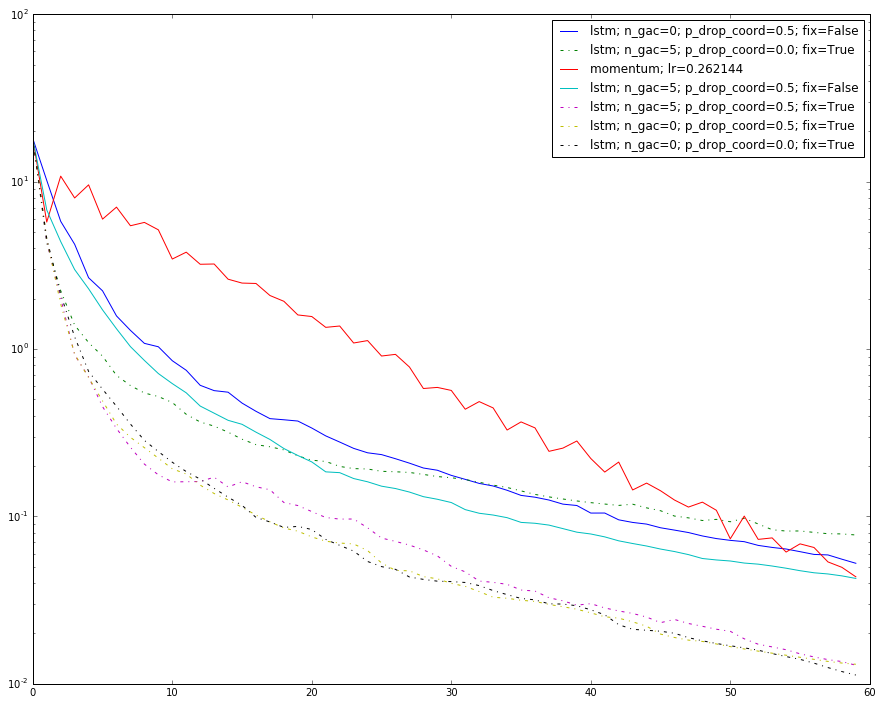

In [ ]:
plt.figure(figsize=(15, 12))
for name, hist in histories_60.items():
    linestyle = 'solid'
    if name.find('fix=True') != -1:
        linestyle = '-.'
    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [ ]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories = test_optimizers(**testing_options)

Testing lstm; n_gac=0; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=False
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=False
Testing momentum


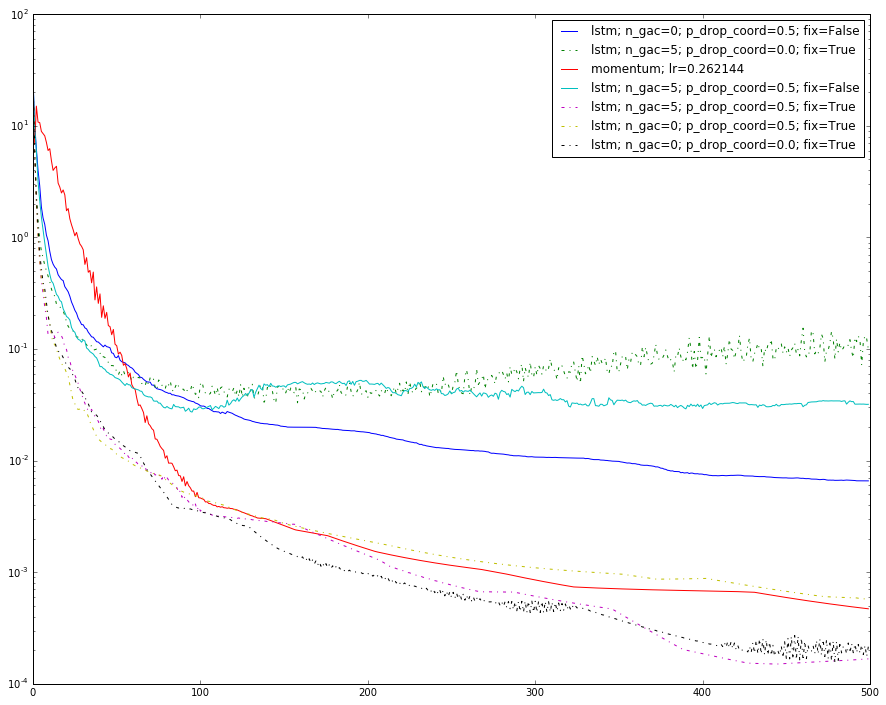

In [ ]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = 'solid'
#     if name.find('lstm') != -1:
#         linestyle = 'solid'
#     elif name.find('0.75') != -1:
#         linestyle = 'dashed'
#     elif name.find('0.5') != -1:
#         linestyle = 'dotted'
    
    if name.find('fix=True') != -1:
        linestyle = '-.'

#     if name.find('p_drop_coord=0.0') == -1:
#         continue


    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [53]:
theta, (W_, b_) = sample_point_and_params_diag(ndim=2)

sample_runs = {}

for name, opt in lstm_optimizers.items():
    history, losses = opt.optimize(theta, [W_, b_], 300)
    #history, losses = opt.loss_det_fn(theta, 300, W_, b_)
    history = np.concatenate([theta.reshape(1, -1), history], axis=0)
    sample_runs[name] = (history, losses)

sample_runs['momentum'] = momentum_fn(theta, 300, W_, b_, 0.262144)
    
# for name, opt in non_lstm_optimizers.items():
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008192:
#             history, losses = opt(theta, 300, W_, b_, lrate)
#             history = [theta] + history

#             sample_runs["{}; lr={}".format(name, lrate)] = (history, losses)

TypeError: ('Bad input argument to theano function with name "<ipython-input-41-25b0b3949e94>:28" at index 2 (0-based)', 'Wrong number of dimensions: expected 2, got 1 with shape (2,).')

TypeError: ('Bad input argument to theano function with name "<ipython-input-41-25b0b3949e94>:28" at index 2 (0-based)', 'Wrong number of dimensions: expected 2, got 1 with shape (2,).')

In [24]:
#theta_opt = np.linalg.pinv(W_).dot(b_)

min_x = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
max_x = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[0])
min_y = min(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])
max_y = max(sample_runs[list(lstm_optimizers.keys())[0]][0].T[1])

delta_x = (max_x - min_x) / 100.
delta_y = (max_y - min_y) / 100.

x = np.arange(2 * min_x - (min_x + max_x) / 2, 2 * max_x - (min_x + max_x) / 2, delta_x)
y = np.arange(2 * min_y - (min_y + max_y) / 2, 2 * max_y - (min_y + max_y) / 2, delta_y)
# x = np.arange(min_x, max_x, delta_x)
# y = np.arange(min_y, max_y, delta_y)
X, Y = np.meshgrid(x, y)

Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        z = ((W_.dot(np.array([X[i][j], Y[i][j]])) - b_)**2).sum()
        Z[i][j] = z

#Z = ((W.dot(X) - b_)**2).sum()

plt.figure(figsize=(15, 12))
plt.title('Trajectory')

CS = plt.contour(X, Y, Z, levels=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1e-0, 5e-0, 1e1])
plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('x1')
plt.ylabel('x2')

for name in lstm_optimizers:
    history, _ = sample_runs[name]
    plt.plot(history.T[0], history.T[1], marker='o', label=name)

history, _ = sample_runs['momentum']
plt.plot(np.array(history).T[0], np.array(history).T[1], label='momentum', marker='o', linestyle='--')

# for name in non_lstm_optimizers:
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008192:
#         #if 1e-4 < lrate < 1e-1 and name != 'sgd':
#             key = "{}; lr={}".format(name, lrate)
#             history, _ = sample_runs[key]
#             plt.plot(np.array(history).T[0], np.array(history).T[1], label=key, marker='o', linestyle='--')

# print(theta_opt)
# plt.plot([theta_opt[0]], [theta_opt[1]], marker='x', color='k')            
# plt.legend();

ValueError: shapes (949,) and (2,) not aligned: 949 (dim 0) != 2 (dim 0)

NameError: name 'sample_runs' is not defined

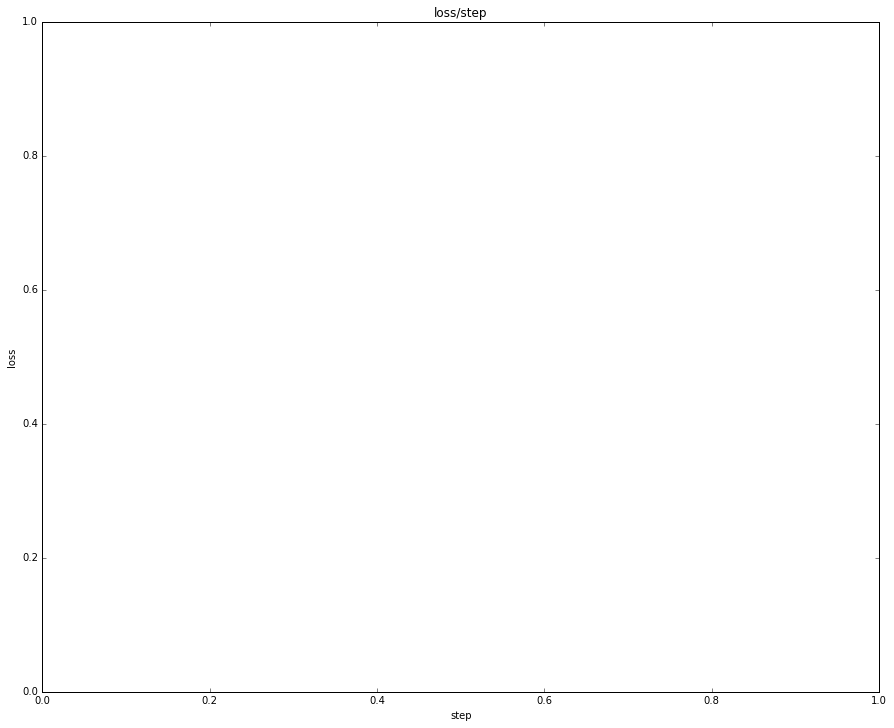

In [24]:
plt.figure(figsize=(15, 12))
plt.title('loss/step')
plt.xlabel('step')
plt.ylabel('loss')

for name in lstm_optimizers:
    _, losses = sample_runs[name]
    plt.semilogy(losses, label=name)

_, losses = sample_runs['momentum']    
plt.semilogy(losses, label='momentum', linestyle='--')

# for name in non_lstm_optimizers:
#     for lrate in np.logspace(0, 29, num=30, base=2.0) * 1e-6:
#         if lrate == 0.008912:
#         #if lrate < 1e-1 and name != 'sgd':
#             key = "{}; lr={}".format(name, lrate)
#             _, losses = sample_runs[key]
#             plt.semilogy(losses, label=key, linestyle='--')
plt.legend();

In [ ]:
import itertools

generalization_loss_lstm = {name: [] for name in lstm_optimizers}

for n_c in itertools.chain(range(2, 50), range(900, 950)):
    print(n_c)

    points_and_params = [sample_point_and_params(ndim=n_c) for _ in range(10)]
    
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for theta, (W_, b_) in points_and_params:
            loss = opt.optimize(theta, [W_, b_], 100)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm[name].append(np.mean(losses))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949


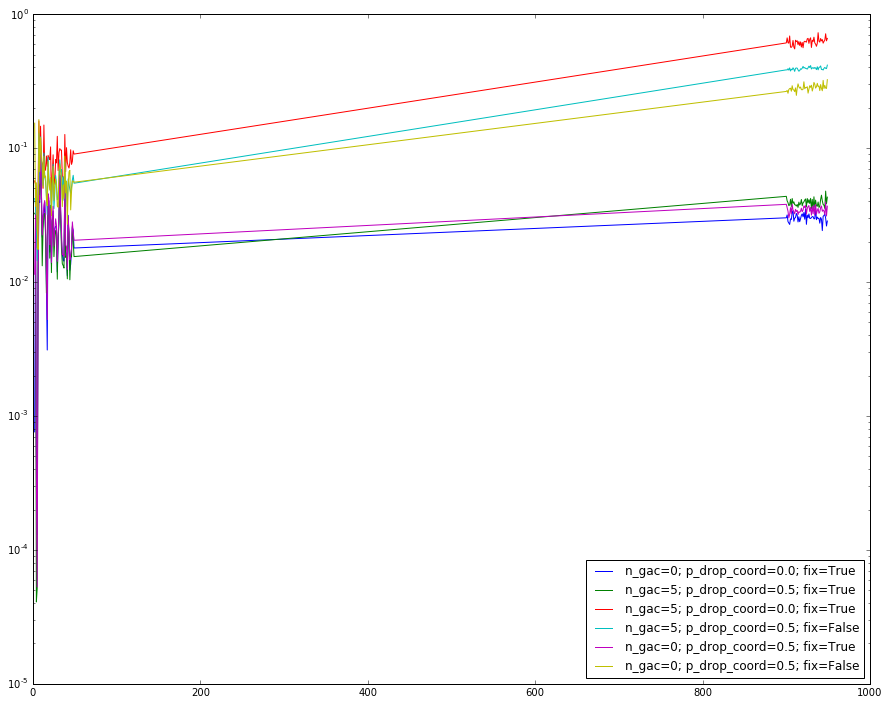

In [27]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm.items():
#     if name.find('momentum') == -1:
#         continue
#     if name != 'momentum' and float(name[12:]) > 0.03125:
#         continue
#     if name.find('momentum') != -1:
#         linestyle = 'dotted'
#     elif name.find('0.75') != -1:
#         linestyle = '-.'
#     else:
#         linestyle = 'solid'
    plt.semilogy(list(range(2, 50)) + list(range(900, 950)), losses[:], label=name)
plt.legend(loc=4);

In [ ]:
for name, opt in lstm_optimizers.items():
    np.savez('drop_samplesame_quadratic_optimizer_({}).npz'.format(name), L.layers.get_all_param_values(opt.l_optim))

In [55]:
import theano.sandbox.cuda.basic_ops as sbcuda
print(sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0]/1024./1024/1024)

4.949436187744141


In [ ]:
for name, opt in lstm_optimizers.items():
    with np.load('drop_quadratic_optimizer_({}).npz'.format(name)) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    L.layers.set_all_param_values(opt.l_optim, param_values[0])

In [ ]:
def test_optimizers_det(**testing_options):
    thetas_and_params = [testing_options['sampler']() for _ in range(testing_options['n_functions'])]
    
    histories = {}
    
    for key, opt in lstm_optimizers.items():
        print("Testing lstm; {key}".format(**locals()))
        loss_history = [] 
        for theta, (W_, b_) in thetas_and_params:
            loss_history.append(opt.loss_det_fn(theta, testing_options['n_iter'], W_, b_)[1])
        histories['lstm; {}'.format(key)] = np.median(loss_history, axis=0)

    lrates = np.logspace(0, 29, num=30, base=2.0) * 1e-6
    
    for name, opt in non_lstm_optimizers.items():
        best_lrate = None
        best_loss = None
        best_history = None

        print("Testing {name}".format(**locals()))
        
        for lrate in lrates:
            loss_history = [] 
            for theta, (W_, b_) in thetas_and_params:
                loss_history.append(opt(theta, testing_options['n_iter'], W_, b_, lrate)[1])
            
            if np.isnan(loss_history).any():
                break
            
            loss = np.median(loss_history, axis=0)[-1]
            if best_loss is None or best_loss > loss:
                best_loss = loss
                best_lrate = lrate
                best_history = np.median(loss_history, axis=0)
                
        histories["{name}; lr={best_lrate}".format(**locals())] = best_history
    return histories

In [ ]:
testing_options = {
    'n_iter': 500,
    'n_functions': 50,
#    'sampler': lambda: sample_point_and_params_diag(np.random.randint(low=0, high=50) + 1)
    'sampler': sample_point_and_params
}

histories_det = test_optimizers_det(**testing_options)

Testing lstm; n_gac=0; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.0; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=5; p_drop_coord=0.5; fix=False
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=True
Testing lstm; n_gac=0; p_drop_coord=0.5; fix=False
Testing momentum


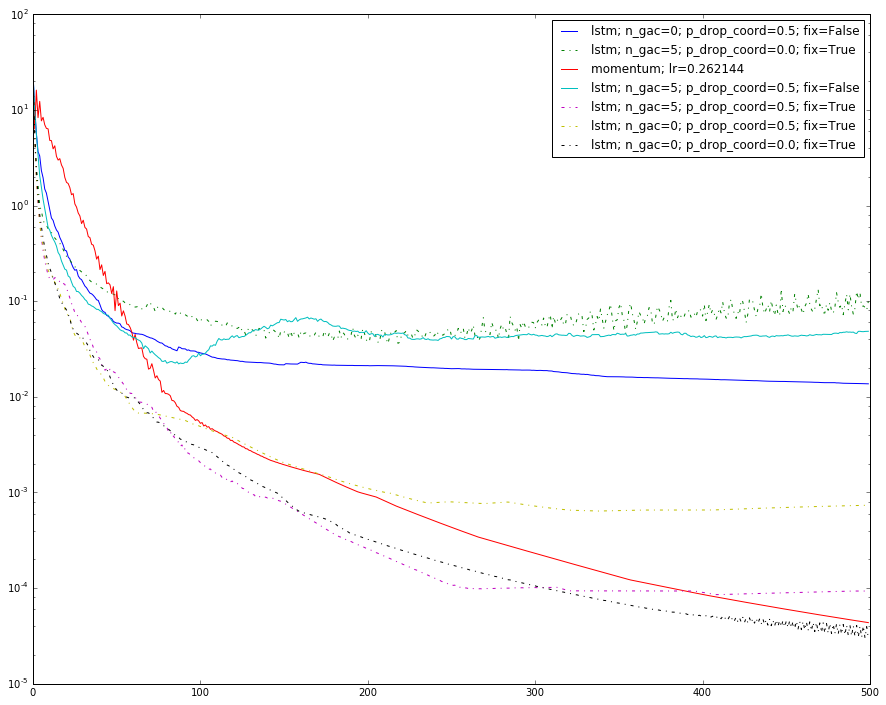

In [ ]:
plt.figure(figsize=(15, 12))
for name, hist in histories_det.items():
    linestyle = 'solid'
#     if name.find('lstm') != -1:
#         linestyle = 'solid'
#     elif name.find('0.75') != -1:
#         linestyle = 'dashed'
#     elif name.find('0.5') != -1:
#         linestyle = 'dotted'
    
    if name.find('fix=True') != -1:
        linestyle = '-.'

#     if name.find('p_drop_coord=0.0') == -1:
#         continue


    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

In [ ]:
import itertools

generalization_loss_lstm_2 = {name: [] for name in lstm_optimizers}

for n_c in itertools.chain(range(2, 150), range(900, 1000)):
    print(n_c)

    points_and_params = [sample_point_and_params(ndim=n_c) for _ in range(10)]
    
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for theta, (W_, b_) in points_and_params:
            loss = opt.optimize(theta, [W_, b_], 100)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm_2[name].append(np.mean(losses))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999


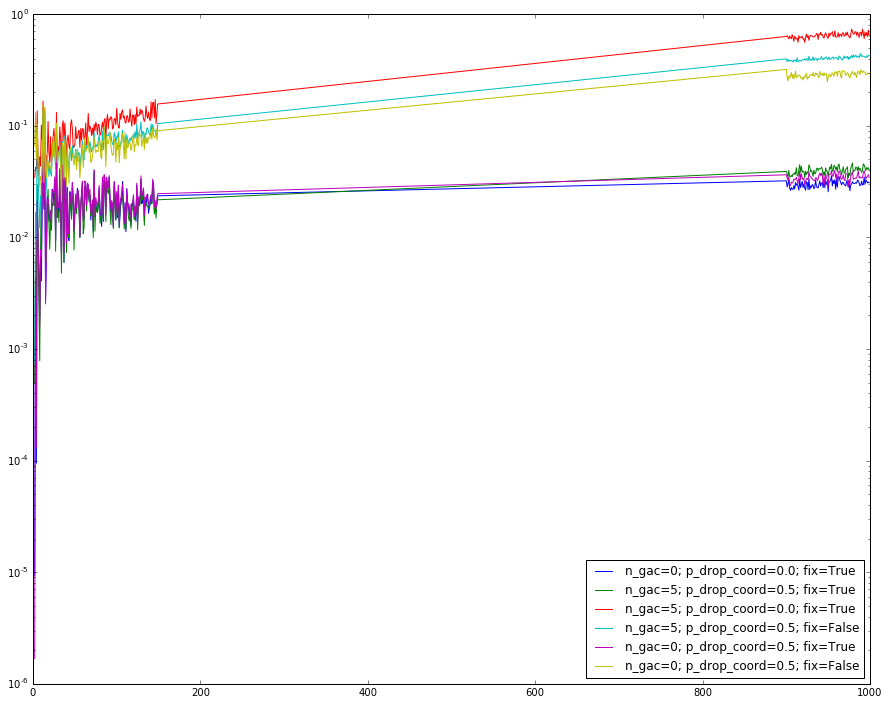

In [ ]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm_2.items():
    plt.semilogy(list(range(2, 150)) + list(range(900, 1000)), losses[:], label=name)
plt.legend(loc=4);

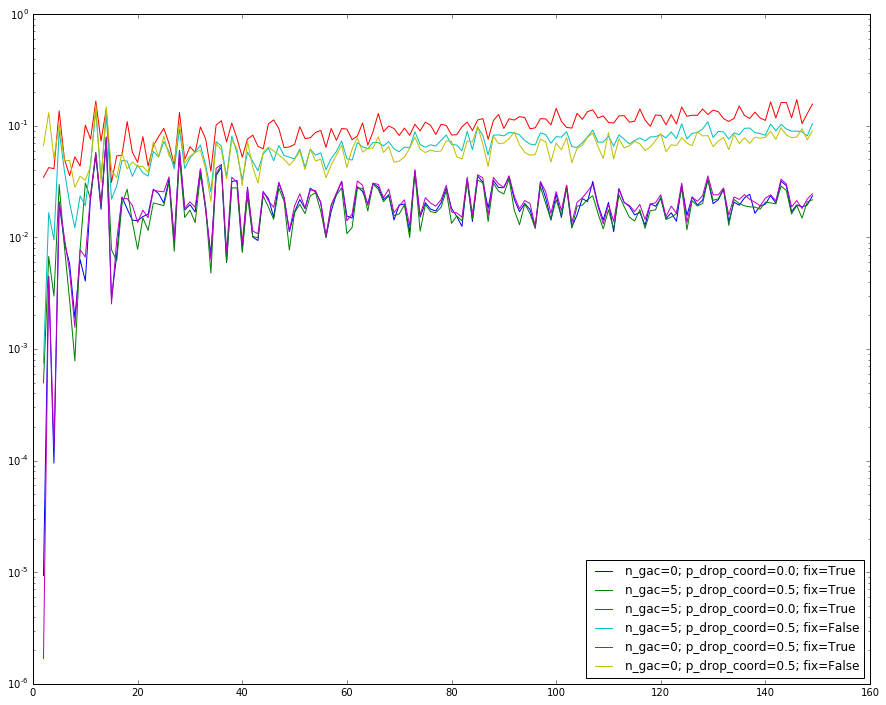

In [ ]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm_2.items():
    plt.semilogy(list(range(2, 150)), losses[:148], label=name)
plt.legend(loc=4);

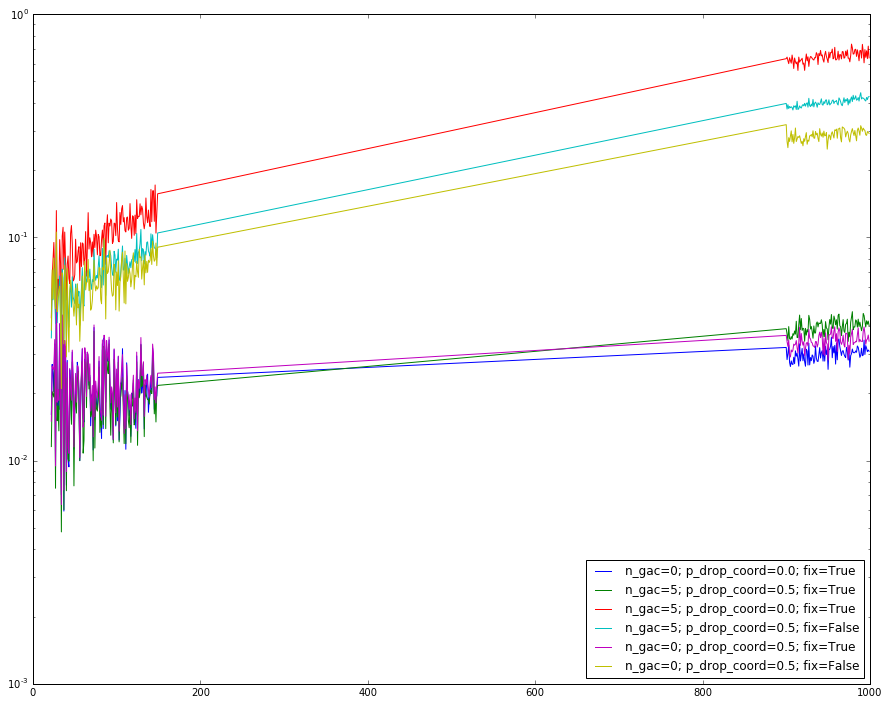

In [28]:
plt.figure(figsize=(15, 12))
for name, losses in generalization_loss_lstm_2.items():
    plt.semilogy(list(range(22, 150)) + list(range(900, 1000)), losses[20:], label=name)
plt.legend(loc=4);

In [1]:
import itertools

generalization_loss_lstm_det = {name: [] for name in lstm_optimizers}

for n_c in itertools.chain(range(2, 150), range(900, 1000)):
    print(n_c)

    points_and_params = [sample_point_and_params(ndim=n_c) for _ in range(10)]
    
    for name, opt in lstm_optimizers.items():
        losses = []
        
        for theta, (W_, b_) in points_and_params:
            loss = opt.loss_det_fn(theta, 100, W_, b_)[1][-1]
            losses.append(loss)
    
        generalization_loss_lstm_det[name].append(np.mean(losses))

NameError: name 'lstm_optimizers' is not defined

In [ ]:
for n_c in itertools.chain(range(2, 150), range(900, 1000)):
    print(n_c)

    points_and_params = [sample_point_and_params(ndim=n_c) for _ in range(10)]
    
    losses = []

    for theta, (W_, b_) in points_and_params:
        loss = momentum_fn(theta, [W_, b_], 100)[1][-1]
        losses.append(loss)

    generalization_loss_lstm_2['momentum'].append(np.mean(losses))

In [2]:
plt.figure(figsize=(15, 12))
for name, hist in histories.items():
    linestyle = 'solid'
#     if name.find('lstm') != -1:
#         linestyle = 'solid'
#     elif name.find('0.75') != -1:
#         linestyle = 'dashed'
#     elif name.find('0.5') != -1:
#         linestyle = 'dotted'
    
    if name.find('fix=True') != -1:
        linestyle = '-.'

#     if name.find('p_drop_coord=0.0') == -1:
#         continue


    plt.semilogy(hist, label=name, linestyle=linestyle)
plt.legend();

NameError: name 'plt' is not defined